In [59]:
import os
import rsgislib 
from rsgislib.segmentation import tiledsegsingle
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from rsgislib.segmentation.shepherdseg import run_shepherd_segmentation
import rasterio
from sklearn.preprocessing import StandardScaler
from rasterio.plot import show
from osgeo import gdal, ogr, osr
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Define Helper functions and directories

In [133]:
tiff_directory = "../test/tiff/"
tiff_name = "18-03-2024.tiff"
shp_directory = "../test/shp/"
max_polygon_shp = "../test/max_polygon_shp/"

In [134]:
"""
Helper functions for the important tasks
"""

# perform segmentation on a tiff image
def segment_tiff(input_image_location):
    output_seg_image = "../test/tiff/segmented.tiff"
    run_shepherd_segmentation(input_image_location, output_seg_image,
                          gdalformat='GTiff',
                          calc_stats=False,
                          num_clusters=20,
                          min_n_pxls=300)

# Generate Shp vector file from raster
def generate_shapefile(input_tiff, output_shapefile, layer_name='output'):
    # Open the raster file
    raster_dataset = gdal.Open(input_tiff)
    if raster_dataset is None:
        print("Error: Could not open the raster file")
        return

    # Get raster band
    band = raster_dataset.GetRasterBand(1)

    # Create output shapefile
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if driver is None:
        print("Error: Could not create shapefile driver")
        return
    data_source = driver.CreateDataSource(output_shapefile)
    if data_source is None:
        print("Error: Could not create data source")
        return

    # Create layer
    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster_dataset.GetProjectionRef())
    layer = data_source.CreateLayer(layer_name, srs, ogr.wkbPolygon)

    # Add field to store pixel value
    field_defn = ogr.FieldDefn('value', ogr.OFTReal)
    layer.CreateField(field_defn)

    # Generate polygons from raster
    gdal.Polygonize(band, None, layer, 0, [], callback=None)

    # Clean up
    data_source = None
    raster_dataset = None

# Extract the layer with the largest area from a shapefile
def extract_largest_polygon_shp(input_file_name):
    # Step 1: Read the Shapefile
    gdf = gpd.read_file(input_file_name)

    # Step 2: Calculate Areas
    gdf['area'] = gdf.geometry.area

    # Step 3: Find the Largest Polygon
    largest_polygon_idx = gdf['area'].idxmax()
    largest_polygon = gdf.loc[largest_polygon_idx]

    # Step 4: Create a New GeoDataFrame
    largest_polygon_gdf = gpd.GeoDataFrame([largest_polygon], crs=gdf.crs)

    # Step 5: Write to a New Shapefile
    output_shapefile = max_polygon_shp+"water.shp"
    largest_polygon_gdf.to_file(output_shapefile)

# Get a polygon area from a shapefile and conve it to km²
def get_polygon_area(input_shp):
    test = gpd.read_file(input_shp)

    # Return the area of the polygon
    #tost = test.copy()
    tost= test.to_crs({'init': 'epsg:32633'})
    tost["area"] = tost['geometry'].area/ 10**6
    #tost.head(2)

    area_value = float(tost['area'].iloc[0])

    # return the area in km²
    return round(area_value, 3)

# Data Preprocessing

## 1/ Segmentation

In [135]:
segment_tiff(tiff_directory+tiff_name)

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
Mask stretched Image.
Deleting file: .\18-03-2024_stchdonly.tif
Deleting file: .\18-03-2024_stchdonly_off.tif
Deleting file: .\18-03-2024_stchdmaskonly.tif
Performing KMeans.
Apply KMeans to image.
Eliminate Single Pixels.
Perform clump.
Eliminate small pixels.
Relabel clumps.
Deleting file: .\18-03-2024_kmeansclusters.gmtxt
Deleting file: .\18-03-2024_kmeans.tif
Deleting file: .\18-03-2024_kmeans.tif.aux.xml
Deleting file: .\18-03-2024_kmeans_nosgl.tif
Deleting file: .\18-03-2024_kmeans_nosgl_tmp.tif
Deleting file: .\18-03-2024_clumps.tif
Deleting file: .\18-03-2024_clumps_elim.tif
Deleting file: .\18-03-2024_stchd.tif


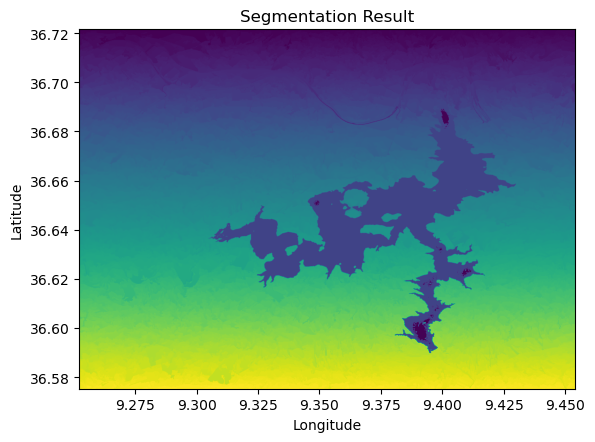

In [136]:
# Path to your raster file
rasterfile_path = "../test/tiff/segmented.tiff"

# Open the raster file
with rasterio.open(rasterfile_path) as src:
    # Read the data from the file
    data = src.read()

    # Get raster extent
    xmin, ymin, xmax, ymax = src.bounds

    # Display the raster data
    fig, ax = plt.subplots()
    show(data, ax=ax, transform=src.transform)  # Display the raster on a specified axes
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('Segmentation Result')
    plt.show()


## 2/ Convert raster (TIFF) to Vector (Shp)

In [137]:
# Example usage
input_tiff = tiff_directory+'segmented.tiff'
output_shapefile = shp_directory+'test.shp'
generate_shapefile(input_tiff, output_shapefile)


## 3/ Extract the largest Polygon

In [138]:
extract_largest_polygon_shp(output_shapefile)

C:\Users\engal\.conda\envs\osgeo-env-v1\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



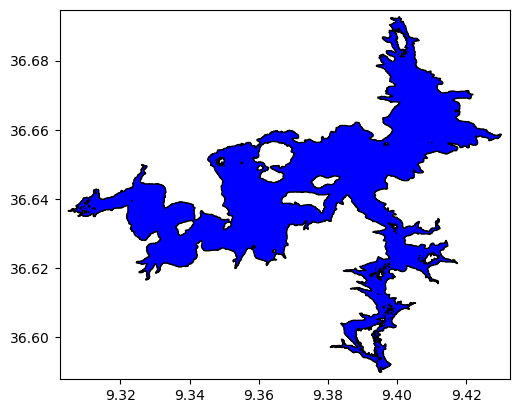

In [139]:
# Extract first layer of features from shapefile using OGR
ds = ogr.Open(max_polygon_shp+"water.shp")
nlay = ds.GetLayerCount()
lyr = ds.GetLayer(0)

# Get extent and calculate buffer size
ext = lyr.GetExtent()
xoff = (ext[1]-ext[0])/50
yoff = (ext[3]-ext[2])/50

# Prepare figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(ext[0]-xoff,ext[1]+xoff)
ax.set_ylim(ext[2]-yoff,ext[3]+yoff)

paths = []
lyr.ResetReading()

# Read all features in layer and store as paths
for feat in lyr:
    geom = feat.geometry()
    codes = []
    all_x = []
    all_y = []
    for i in range(geom.GetGeometryCount()):
        # Read ring geometry and create path
        r = geom.GetGeometryRef(i)
        x = [r.GetX(j) for j in range(r.GetPointCount())]
        y = [r.GetY(j) for j in range(r.GetPointCount())]
        # skip boundary between individual rings
        codes += [mpath.Path.MOVETO] + \
                     (len(x)-1)*[mpath.Path.LINETO]
        all_x += x
        all_y += y
    path = mpath.Path(np.column_stack((all_x,all_y)), codes)
    paths.append(path)

# Add paths as patches to axes
for path in paths:
    patch = mpatches.PathPatch(path, \
            facecolor='blue', edgecolor='black')
    ax.add_patch(patch)

ax.set_aspect(1.0)
plt.show()

## 4/ Extract the area of the water body

In [141]:
area = get_polygon_area(max_polygon_shp+"water.shp")
area # in kM²

C:\Users\engal\.conda\envs\osgeo-env-v1\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


26.615

# Predict Volume

In [99]:
# Load the CSV file into a DataFrame
df = pd.read_csv('../csv/dataset.csv') 

In [100]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


ValueError: Found input variables with inconsistent numbers of samples: [204, 19]

In [65]:
# Assuming 'surface_data' contains the features for a single data point
surface_data = np.array([area])  # Replace <your_feature_values_here> with actual feature values

# Reshape the data to match the format expected by the model
surface_data_reshaped = surface_data.reshape(1, -1)

# Make prediction on the surface data
predicted_surface_volume = rf_regressor.predict(surface_data_reshaped)

print("Predicted surface volume:", predicted_surface_volume[0])

Predicted surface volume: 136.37156999999996


C:\Users\engal\.conda\envs\osgeo-env-v1\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
